In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

# Funkcje

In [2]:
def order_points(pts):
    # Order: top-left, top-right, bottom-right, bottom-left
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]    # top-left
    rect[2] = pts[np.argmax(s)]    # bottom-right
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)] # top-right
    rect[3] = pts[np.argmax(diff)] # bottom-left
    return rect

In [36]:
def divide_cells(img):
    width, height = img.shape
    for x_div in np.arange(0, 252, 28):
        for y_div in np.arange(0, 252, 28):
            cell_arr = img[x_div:x_div+28, y_div:y_div+28]
            cell_id = "cell_" + str(x_div//28) + "_" + str(y_div//28) 
            cv.imwrite(cell_id + '.jpg', cell_arr)

In [73]:
def standardize_cell(img):
    # Wczytaj obraz w odcieniach szarości
    gray = cv.imread('cell_8_2.jpg', cv.IMREAD_GRAYSCALE)

    # 1. Skalowanie do 0–1
    gray_norm = gray.astype(np.float32) / 255.0

    # 2. Binaryzacja
    binary = cv.adaptiveThreshold(gray, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C,
                                  cv.THRESH_BINARY, 3, 2)

    # 3. Czyszczenie krawędzi (np. zamalowanie ramek)
    binary[:4, :] = 255
    binary[-4:, :] = 255
    binary[:, :4] = 255
    binary[:, -4:] = 255

    # (opcjonalnie) Czyszczenie przez morfologię
    kernel = np.ones((3,3), np.uint8)
    cleaned = cv.morphologyEx(binary, cv.MORPH_OPEN, kernel)
    
    #print(cleaned)
    
    
    cv.imwrite('cell_8_2_cleaned.jpg', cleaned)
    
    if np.count_nonzero(cleaned) < 10:
        print("Blank or nearly blank")
    else:
        print("Not blank")
    
standardize_cell('')

Not blank


# Wstępna obróbka zdjęć

In [58]:
img = cv.imread('data/image1072.jpg', 0)

In [59]:
width, height = img.shape

In [60]:
#gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

In [61]:
blur = cv.GaussianBlur(img, (5,5), 0)

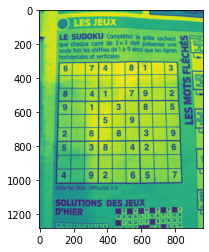

In [62]:
plt.imshow(blur)

In [63]:
#th = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_MEAN_C,\
#            cv.THRESH_BINARY,11,2)
th = cv.adaptiveThreshold(blur, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv.THRESH_BINARY_INV, 11, 2)

In [64]:
#np.where(th=255)

In [65]:
contours, _ = cv.findContours(th, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

In [66]:
max_area = 0
biggest_square = None
size = 0

for cnt in contours:
    peri = cv.arcLength(cnt, True)
    approx = cv.approxPolyDP(cnt, 0.02 * peri, True)
    area = cv.contourArea(approx)
    if len(approx) == 4 and area > max_area:
        # Optionally check if it's "square enough" (aspect ratio ~1)
        x, y, w, h = cv.boundingRect(approx)
        aspect_ratio = float(w)/h
        if 0.8 < aspect_ratio < 1.2:  # adjust as needed
            max_area = area
            biggest_square = approx
            size = np.max([w,h])

In [67]:
mask = np.zeros_like(blur)
cv.drawContours(mask, [biggest_square], -1, (255), thickness=cv.FILLED)
masked = cv.bitwise_and(blur, blur, mask=mask)

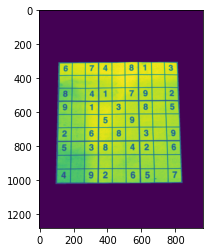

In [68]:
plt.imshow(masked)

In [69]:
pts_src = biggest_square.reshape(4, 2).astype(np.float32)
ordered_pts_src = order_points(pts_src)

In [70]:
width = 252
height = 252
#width = np.max(w,h)
pts_dst = np.float32([
    [0, 0],
    [width-1, 0],
    [width-1, height-1],
    [0, height-1]
])


In [71]:
M = cv.getPerspectiveTransform(ordered_pts_src, pts_dst)
sudoku_board = cv.warpPerspective(masked, M, (252, 252))

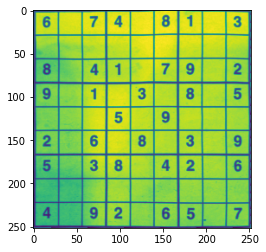

In [72]:
plt.imshow(sudoku_board)

In [37]:
divide_cells(sudoku_board)